In [5]:
import torch 
import logging
import random 
from mlca_for_elec.networks.main import eval_config
import os
import matplotlib.pyplot as plt
from mlca_for_elec.env.env import Microgrid, HouseHold
from mlca_for_elec.mlca_elec.mlca import *
import json
import numpy as np
from collections import defaultdict
import pandas as pd

Class NN_MIP_TORCH imported
Class MLCA_WDP imported
Class MLCA_Economies imported
FUNCTION MLCA imported


In [6]:
os.getcwd()
os.chdir("c:\\Users\\pieples\\Documents\\MLICA-for-elec\\")

In [7]:
exp_number = 1

In [8]:
household_path = f"config\experiment{exp_number}\households"
microgrid_path = f"config\experiment{exp_number}\microgrid\exp{exp_number}_microgrid.json"
dataset_path = f"config\experiment{exp_number}\dataset"

# Setup

In [9]:
%matplotlib inline
print("Start loading household profiles")
folder_path = household_path
houses = []
for file in os.listdir(folder_path)[:3]:
    if file.endswith(".json"):
        household = json.load(open(folder_path+"/"+ file))
    house = HouseHold(household)

    generation_path = "data\solar_prod\Timeseries_55.672_12.592_SA2_1kWp_CdTe_14_44deg_-7deg_2020_2020.csv"
    consumption_path = f"data/consumption/Reference-{house.param['consumption']['type']}.csv"
    spot_price_path = "data/spot_price/2020.csv"
    fcr_price_path = "data/fcr_price/random_fcr.csv"
    profile_path_train = dataset_path + f"/dataset_{house.ID}.csv"
    profile_path_valtest = dataset_path + f"/test_dataset_{house.ID}.csv"
    house.load_data(generation_path,consumption_path, spot_price_path,fcr_price_path, profile_path_train, profile_path_valtest,type = float)
    for i in range(0):
        house.next_data()
    houses.append(house)
print(f"Loaded {len(houses)} households")
print("Start compute social welfare")
print(list(houses[0].data['consumption'].to_numpy()))
microgrid_1 =json.load(open( microgrid_path))
MG = Microgrid(houses, microgrid_1)
optimal_allocation = {}
for house in MG.households:
    print(house.data['consumption'].sum())
    optimal_allocation_tuple = MG.get_efficient_allocation()
    optimal_allocation[house.ID] = (optimal_allocation_tuple[0][house.ID] , MG.calculate_value(house.ID, optimal_allocation_tuple[0][house.ID]))


Start loading household profiles
0
1
2
Loaded 3 households
Start compute social welfare
[1.3486959329357744, 1.0877501067919773, 1.046067294300736, 1.0232273970452614, 1.5571099953919798, 2.6484764192494072]
8.711327145715137
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 3.13102282521363
  Upper bound: 3.13102282521363
  Number of objectives: 1
  Number of constraints: 193
  Number of variables: 187
  Number of nonzeros: 454
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and

# Display experiment 

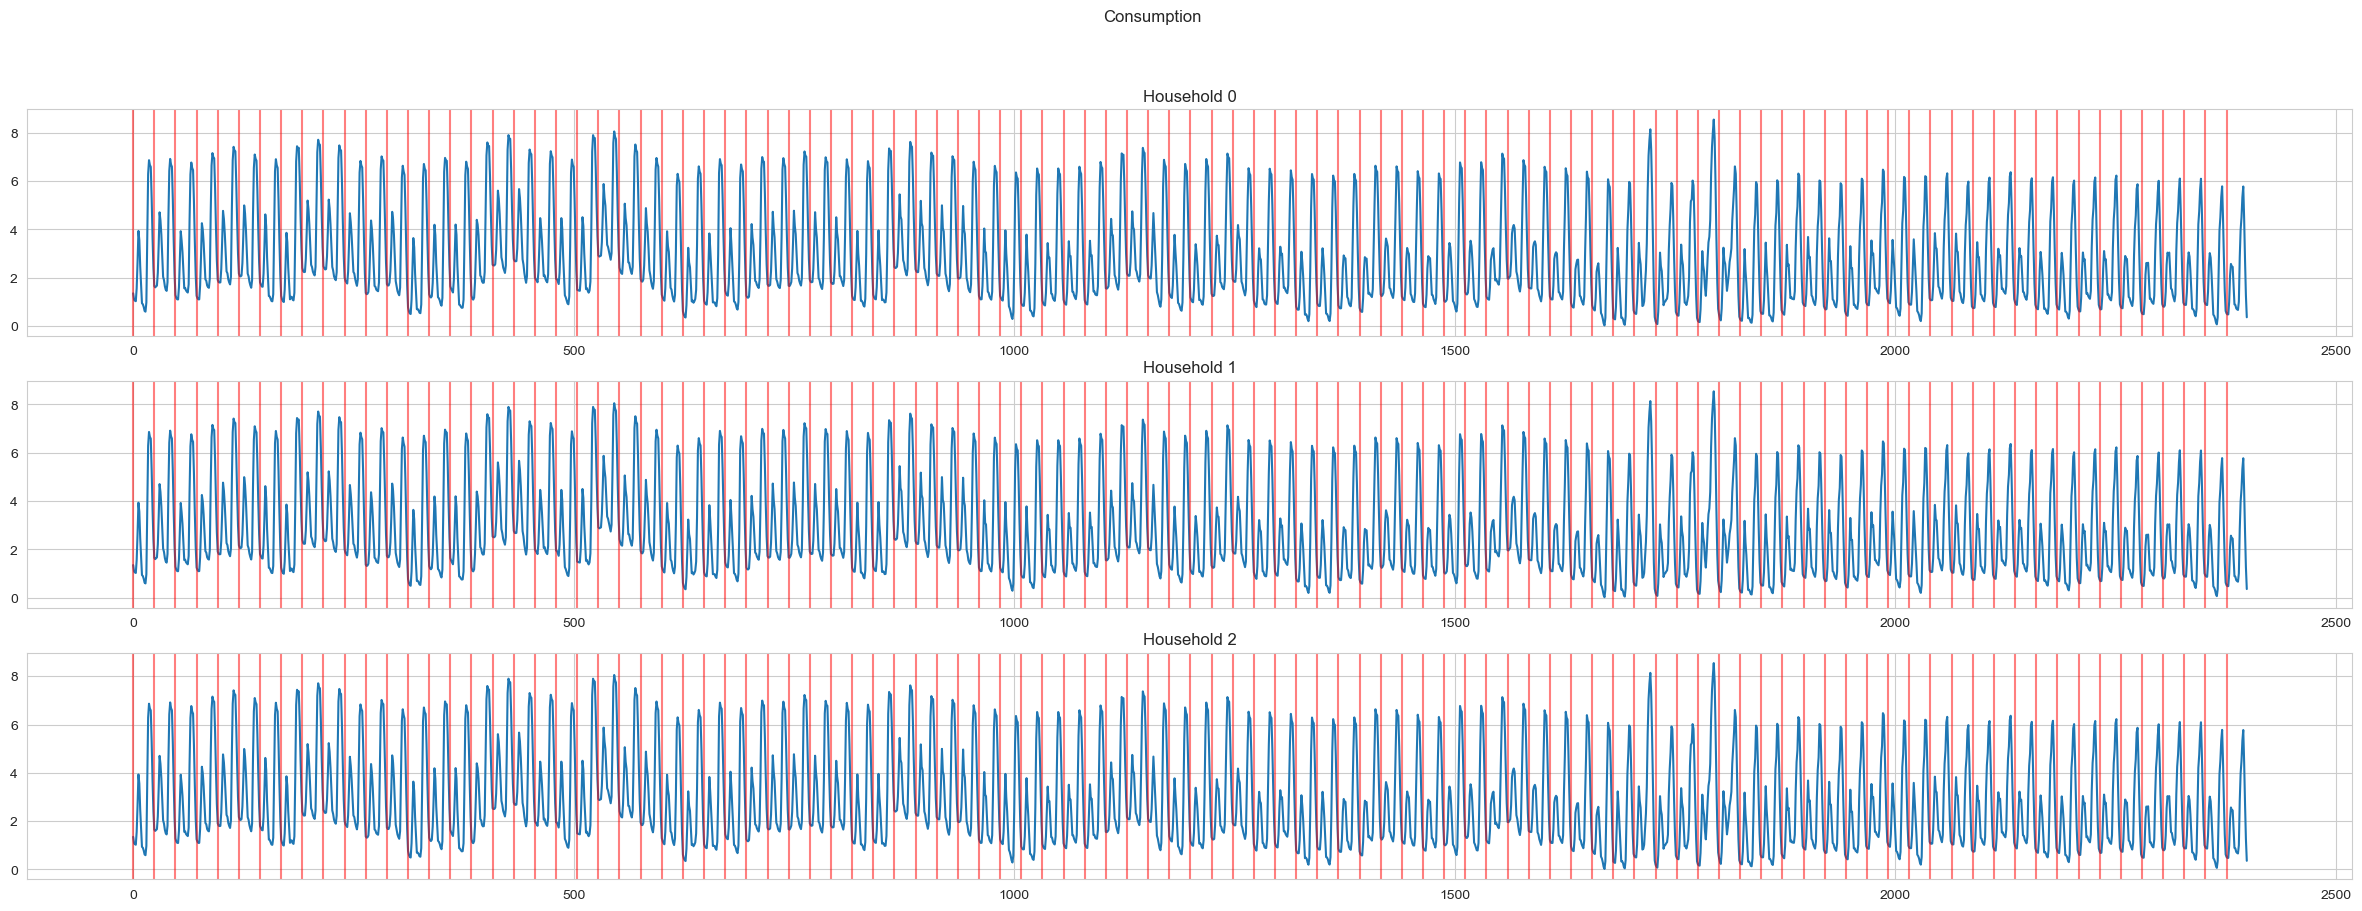

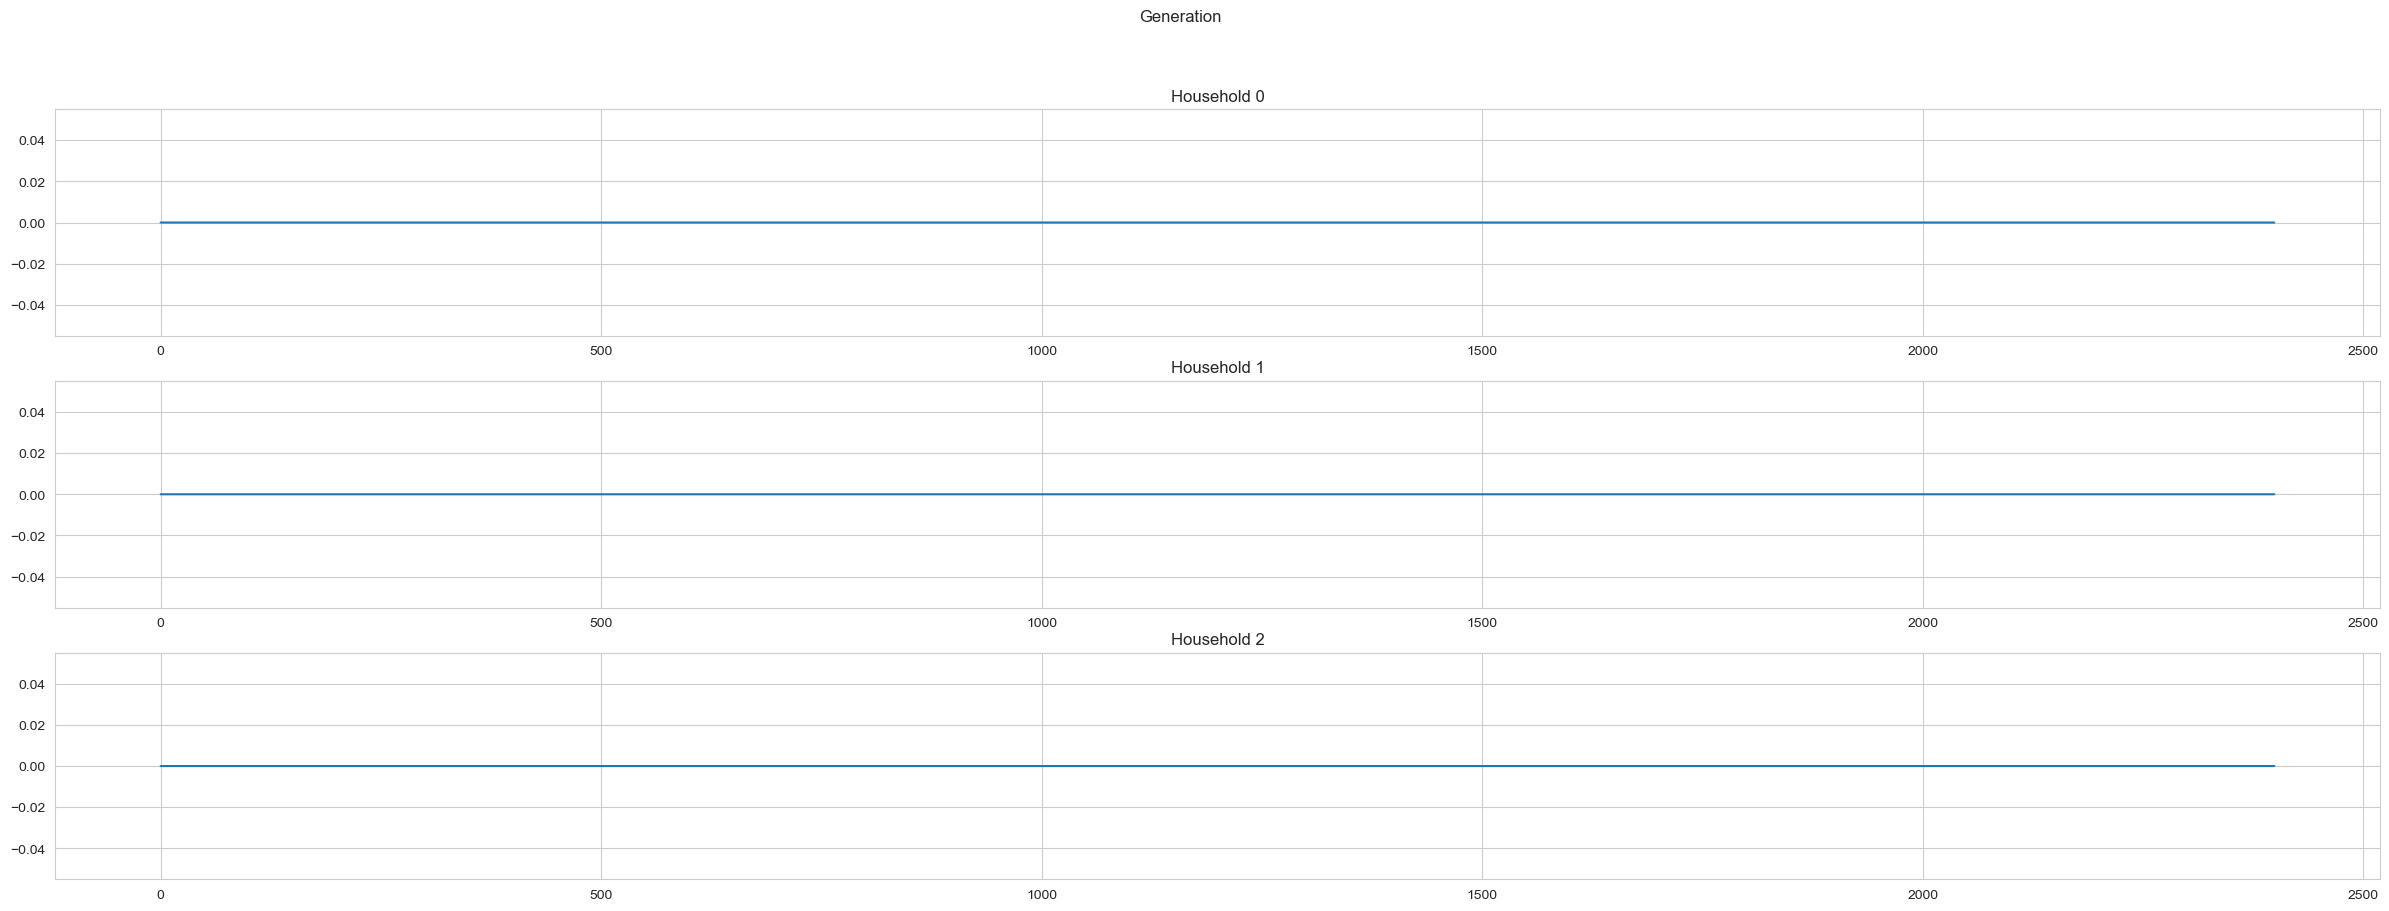

In [10]:
# plot data per houses 
fig, ax = plt.subplots(len(MG.households),1, figsize = (30,10))
for i,house in enumerate(MG.households):
    ax[i].plot(house.df['consumption'], label = "consumption")
    ax[i].set_title(f"Household {house.ID}")
    for t in range(0,len(house.df),24):
        ax[i].axvline(t, color = "red", alpha = 0.5)
plt.suptitle("Consumption")
plt.show()

# plot data per houses 
fig, ax = plt.subplots(len(MG.households),1, figsize = (30,10))
for i,house in enumerate(MG.households):
    ax[i].plot(house.df['generation'], label = "Generation")
    ax[i].set_title(f"Household {house.ID}")
plt.suptitle("Generation")
plt.show()

## Dataset Generation

In [11]:

MG.generate_dataset(1,dataset_path,1000)
MG.generate_test_dataset(1,dataset_path,50000)

-----------------------------------
Generating dataset
-----------------------------------
Generating dataset for bidder 1
Optimal allocation is : 
1.7456918193432576


100%|██████████| 1000/1000 [00:00<00:00, 7181.87it/s]

-----------------------------------
Generating test dataset
-----------------------------------
Generating test dataset for bidder 1
Optimal allocation is : 


1.7456918193432576


100%|██████████| 50000/50000 [00:06<00:00, 7478.30it/s]


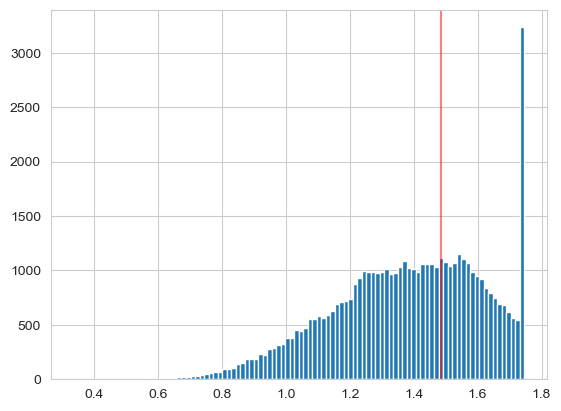

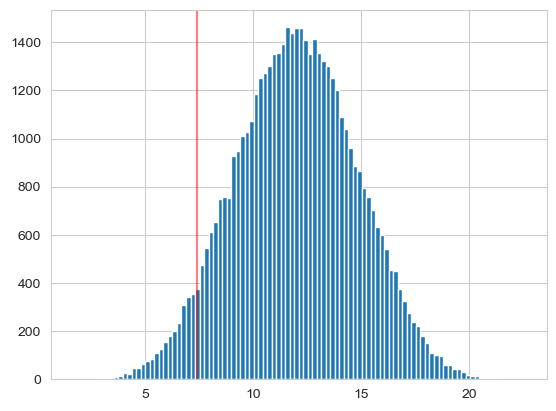

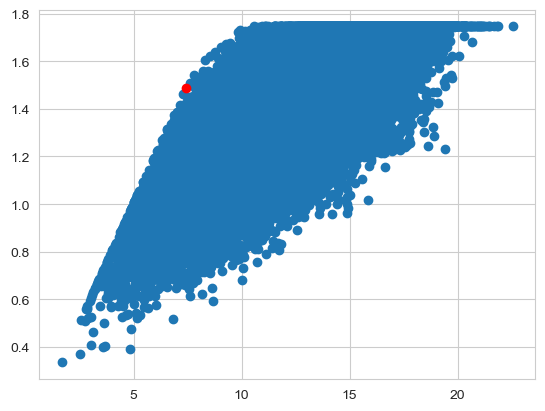

In [12]:


df = pd.read_csv(f"config\experiment{exp_number}\dataset/test_dataset_1.csv", index_col = 0)
df.value.hist(bins = 100)
plt.axvline(optimal_allocation[1][1], color = "red", alpha = 0.5)
plt.show()
df.drop(columns="value").sum(axis = 1).hist(bins = 100)
df.drop(columns="value").sum(axis = 1)
plt.axvline(optimal_allocation[1][0].sum(), color = "red", alpha = 0.5)
plt.show()
plt.scatter(df.drop(columns="value").sum(axis = 1), df.value, alpha = 1)
plt.scatter(optimal_allocation[1][0].sum(), optimal_allocation[1][1], color = "red", alpha = 1)
plt.show()

# df.drop(columns="value")

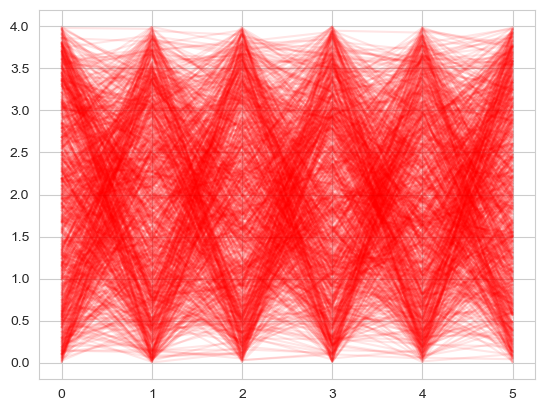

In [100]:
for traj in df.drop(columns="value")[:1000].to_numpy():
    plt.plot(traj, color = "r", alpha=0.1)

# Hyper Parameters optimization


for hyperparamter optimizations we use optuna

In [101]:
def evaluate_network(cfg: dict, seed: int, MicroGrid_instance: str, bidder_id: str, num_train_data: int, layer_type: str,
                     normalize: bool, normalize_factor: float, eval_test=False, save_datasets=False):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return eval_config(
        seed=seed, SAT_instance=MicroGrid_instance, bidder_id=bidder_id,
        layer_type=layer_type, batch_size=cfg['batch_size'], num_hidden_layers=cfg['num_hidden_layers'],
        num_hidden_units=int(max(1, np.round(cfg['num_neurons'] / cfg['num_hidden_layers']))), l2=cfg['l2'], l1 =cfg['l1'],
        lr=cfg['lr'], normalize_factor=normalize_factor, optimizer=cfg['optimizer'], num_train_data=num_train_data,
        eval_test=True, epochs=cfg['epochs'], loss_func=cfg['loss_func'], normalize=normalize, save_datasets=False, log_path="logs", ts = cfg["ts"], state_dict = cfg["state_dict"], plot=True)

In [102]:
# load bestparam 
%matplotlib inline
import optuna
bidder_id = 1
nitems=50

layer = "CALayerReLUProjected"
layer = "PlainNN"
study = optuna.load_study(study_name=f"Exp_{exp_number}_bidder{bidder_id}_nitems_{nitems}_layer_{layer}", storage="sqlite:///db_sqlite.db")
config_dict = study.best_params
print(config_dict)
# add relevant parameters

config_dict["ts"] = 1
config_dict["loss_func"] = "F.l1_loss"
config_dict["state_dict"] = None
# base parameters

normalize_factor = 1

# Run model

print('Selected hyperparameters', config_dict)
model, logs = evaluate_network(
        config_dict, seed=0, MicroGrid_instance=MG, bidder_id=bidder_id,
        num_train_data = nitems  ,layer_type=config_dict["model"],
        normalize=True,
        normalize_factor= normalize_factor)
train_logs = logs['metrics']['train'][config_dict['epochs']]
val_logs = logs['metrics']['val'][config_dict['epochs']]
test_logs = logs['metrics']['test'][config_dict['epochs']]
print('Train metrics \t| mae: {:.3f}, pearson corr.: {:.3f}, KT: {:.3f}'.format(train_logs['mae'], train_logs['r'], train_logs['kendall_tau']))
print('Valid metrics \t| mae: {:.3f}, pearson corr.: {:.3f}, KT: {:.3f}'.format(val_logs['mae'], val_logs['r'], val_logs['kendall_tau']))
print('Test metrics \t| mae: {:.3f}, pearson corr.: {:.3f}, KT: {:.3f}'.format(test_logs['mae'], test_logs['r'], test_logs['kendall_tau']))
best_result = (test_logs['mae'], config_dict, model)

{'batch_size': 2, 'epochs': 178, 'l1': 3.280855343422425e-05, 'l2': 7.515947297781839e-05, 'lr': 0.0009352234527162049, 'model': 'PlainNN', 'num_hidden_layers': 2, 'num_neurons': 10, 'optimizer': 'Adam'}
Selected hyperparameters {'batch_size': 2, 'epochs': 178, 'l1': 3.280855343422425e-05, 'l2': 7.515947297781839e-05, 'lr': 0.0009352234527162049, 'model': 'PlainNN', 'num_hidden_layers': 2, 'num_neurons': 10, 'optimizer': 'Adam', 'ts': 1, 'loss_func': 'F.l1_loss', 'state_dict': None}
Dataset size : Train (50, 6), Val (1000, 6), Test (4000, 6)
(50, 6) (50,) (1000, 6) (1000,) (4000, 6) (4000,)


100%|██████████| 178/178 [00:09<00:00, 18.53it/s]


Train metrics 	| mae: 0.064, pearson corr.: 0.926, KT: 0.780
Valid metrics 	| mae: 0.095, pearson corr.: 0.000, KT: 0.691
Test metrics 	| mae: 0.094, pearson corr.: 0.000, KT: 0.701


In [103]:
best_result

(0.09370072908699513,
 {'batch_size': 2,
  'epochs': 178,
  'l1': 3.280855343422425e-05,
  'l2': 7.515947297781839e-05,
  'lr': 0.0009352234527162049,
  'model': 'PlainNN',
  'num_hidden_layers': 2,
  'num_neurons': 10,
  'optimizer': 'Adam',
  'ts': 1,
  'loss_func': 'F.l1_loss',
  'state_dict': None},
 Net(
   (layers): ModuleList(
     (0): Linear(in_features=6, out_features=5, bias=True)
     (1): Linear(in_features=5, out_features=5, bias=True)
   )
   (output_layer): Linear(in_features=5, out_features=1, bias=True)
 ))

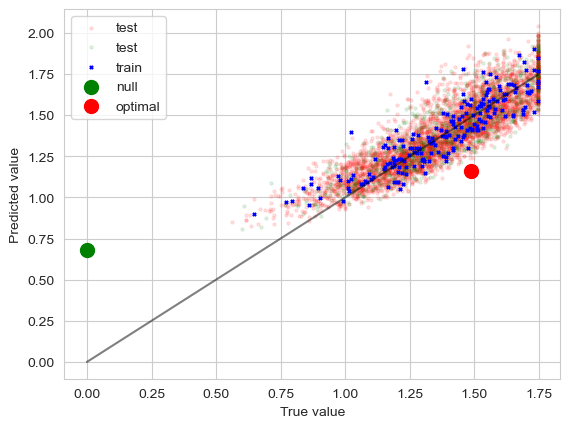

In [104]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
best_model = best_result[2]
profile_train = pd.read_csv(f"config\experiment{exp_number}\dataset/dataset_1.csv")
bids = profile_train.to_numpy()[:,1:-1]
value = profile_train.to_numpy()[:,-1]
n_item = 200

bids_train = torch.Tensor(bids[:n_item])
target_train = value[:n_item]
target_max = target_train.max()* (1 / normalize_factor)
n_item = 1000000
profile_test = pd.read_csv(f"config\experiment{exp_number}\dataset/test_dataset_1.csv", nrows = n_item)
bids = profile_test.to_numpy()[:,1:-1]
value = profile_test.to_numpy()[:,-1]

bids_val = torch.Tensor(bids)[:int(len(bids)*0.2)]
target_val = value[:int(len(bids)*0.2)]

bids_test = torch.Tensor(bids)[int(len(bids)*0.2):]
null_test = torch.zeros_like(bids_test[1])
target_test = value[int(len(bids)*0.2):]




# Scale targets
target_train = target_train /target_max
target_val = target_val /target_max
target_test = target_test /target_max


pred_train = best_model(bids_train)
pred_val = best_model(bids_val)
pred_test = best_model(bids_test)
pred_null = best_model(null_test)

#plt.xlim(-0.1, target_max*1.1)#
# plt.ylim(-0.1, target_max*1.1)#
dat_min, dat_max = min(min(pred_train), min(target_train)), \
                           max(max(pred_train), max(target_train))
plt.plot([0,target_train.max()*target_max], [0, normalize_factor*target_max], color = "black", alpha=0.5)
#plt.plot([dat_min, dat_max], [dat_min, dat_max], 'y')
plt.scatter(target_test*target_max, pred_test.detach().numpy()*target_max, label = "test", marker="o", color = "r", alpha=0.1,s=5)
plt.scatter(target_val*target_max, pred_val.detach().numpy()*target_max, label = "test", marker="o", color = "g", alpha=0.1,s=5)
# plt.scatter(target_synth*target_max, pred_synth.detach().numpy()*target_max, marker="o", color = "r", alpha =0.1, s=5)
plt.scatter(target_train*target_max, pred_train.detach().numpy()*target_max, label = "train", marker="x", color = "b", s=5)
plt.scatter(0, pred_null.detach().numpy()*target_max, label = "null", marker="o", color = "g", s=100)
plt.scatter(optimal_allocation[1][1],  best_model(torch.Tensor(optimal_allocation[1][0])).detach().numpy()*target_max, label = "optimal", marker="o", color = "r", s=100)
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.legend()
plt.show()

In [ ]:
plt.hist(target_test*target_max, bins=100)
plt.hist( pred_test.detach().numpy()*target_max, bins = 100, alpha = 0.8)
# plt.stem(target_train*target_max, [1500 for i in target_train])
plt.show()


In [ ]:
target_test.shape,pred_test.detach().numpy().shape

In [ ]:
best_model = best_result[2]
conso = MG.households[0].data["consumption"]
def calculate_value(bid):
    return sum(map(lambda x: min(x[0],x[1])*0.2, zip(bid, conso)))

X,Y = np.meshgrid(np.linspace(0,4,100),np.linspace(0,4,100))
C= 0*np.zeros((100,100))
C_opt= 0*np.zeros((100,100))
vec =0*np.ones(6)
for i in range(100):
    for j in range(100):
            vec[2] = X[i,j]
            vec[3] = Y[i,j]
            C[i,j] = best_model(torch.tensor(vec).float()).detach().numpy()*target_max
            C_opt[i,j] = calculate_value(vec)

In [ ]:
%matplotlib inline
print(conso)
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure()
ax = fig.add_subplot()
#ax.contour(X, Y, C, levels =20)
c = ax.contourf(X, Y, C, levels =50, cmap="viridis")
ax.set_xlabel('Qtty in Hour 0 kW')
ax.set_ylabel('Qtty in Hour 1 kW')
ax.axhline(conso[1], color = "black", label = "conso hour 1", linestyle="--")
ax.axvline(conso[4], color = "red", label = "conso hour 0", linestyle="--")

ax.legend()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')
ax.set_title(" Shape of the valuation function projected on 2 timeslots (others equal to 1)")
plt.show()

# MLCA auctions

In [ ]:
%matplotlib inline
import optuna
Qinit =nitems
Qmax = nitems + 10
Qround=1
L=3000
sample_weight_on = False
sample_weight_scaling = None
min_iteration = 1
seed_instance = 12
model_name = 'MVNN'
Mip_bounds_tightening = "IA"
warm_start=False
NN_parameters = {f"Bidder_{i}" : {} for i in range(len(MG.households))}
loacal_scaling_factor = 1

NN_parameters = defaultdict(dict)



study = optuna.load_study(study_name=f"Exp_{exp_number}_bidder{bidder_id}_nitems_{nitems}_layer_{layer}", storage="sqlite:///db_sqlite.db")
config_dict = study.best_params
print(config_dict)
# add relevant parameters

config_dict["ts"] = 1
config_dict["loss_func"] = "F.l1_loss"
config_dict["state_dict"] = {0 : None, 1 : None, 2 :None} 
# base parameters

normalize_factor = 1





# {0 : None, 1 : None, 2 :None} 
#  {0 : "config\experiment1\model_0.pt", 1 : "config\experiment1\model_1.pt", 2 : "config\experiment1\model_2.pt"}
for house in MG.households:
    for key, value in config_dict.items():
        if key == "state_dict":
            NN_parameters[f"Bidder_{house.ID}"]['state_dict'] = value[house.ID]
        else:    
            NN_parameters[f"Bidder_{house.ID}"][key] = value
    
    NN_parameters[f"Bidder_{house.ID}"]['layer_type'] = config_dict["model"]    

    NN_parameters[f"Bidder_{house.ID}"]['num_hidden_units'] = int(max(1, np.round(
        NN_parameters[f"Bidder_{house.ID}"]['num_neurons'] / NN_parameters[f"Bidder_{house.ID}"]['num_hidden_layers'])))
    NN_parameters[f"Bidder_{house.ID}"].pop('num_neurons')

# NN_parameters = value_model.parameters_to_bidder_id(NN_parameters)


MIP_parameters = {
        'bigM': 2000,
        'mip_bounds_tightening': None,
        'warm_start': False,
        'time_limit' :300,
        'relative_gap': 1e-2,
        'integrality_tol': 1e-6,
        'attempts_DNN_WDP': 5
    }



RESULT = mlca_mechanism(value_model = MG, 
    
    Qinit = Qinit,
    Qmax = Qmax,
    Qround = Qround,
    MIP_parameters=MIP_parameters,
    NN_parameters=NN_parameters,
    scaler=None,
    calc_efficiency_per_iteration=True, 
    local_scaling_factor=loacal_scaling_factor,
    )

print(RESULT[1]['MLCA Payments'])
